# This code can be executed by uploading code to Google Colab

-with GPU enabled



>Convolution Neural Nets(CNN) using google word2vec word-embedding

In [ ]:
# install gensim package ( google colab)
!pip install -q gensim

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth,files
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
csv_import = drive.CreateFile({'id':'11DI36Rpqnk-X0RTnFP6xnMVurYb20W94'})

csv_import.GetContentFile('data.csv')

W0831 04:54:21.131694 140133520877440 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [ ]:
csv_import = drive.CreateFile({'id':'1TtUeEAj2YaLiBoflMI9JkntJZ93liikg'})

csv_import.GetContentFile('bad_words.csv')

In [ ]:
csv_import = drive.CreateFile({'id':'0B7XkCwpI5KDYNlNUTTlSS21pQmM'})

csv_import.GetContentFile('GoogleNews-vectors-negative300.bin.gz')

# Loading Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%precision %.2f

import re

# Importing required libraries
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Embedding

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

# gensim
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# defining function to clean text and retrive closs-validation datasets
def cleantxt(txt):
    """
    Cleans the string passed. Cleaning Includes-
    1. remove special characters/symbols
    2. convert text to lower-case
    3. retain only alphabets
    4. remove words less than 3 characters
    5. remove stop-words
    """  
    # collecting english stop words from nltk-library
    stpw = stopwords.words('english')
    
    # Adding custom stop-words
    stpw.extend(['www','http','utc'])
    stpw = set(stpw)
    
    # using regex to clean the text
    txt = re.sub(r"\n", " ", txt)
    txt = re.sub("[\<\[].*?[\>\]]", " ", txt)
    txt = txt.lower()
    txt = re.sub(r"[^a-z ]", " ", txt)
    txt = re.sub(r"\b\w{1,3}\b", " ",txt)
    txt = " ".join([x for x in txt.split() if x not in stpw])
    return txt


def load_data():
    """
    Loads data and returns train, val, and test splits
    """
    # Load the train dataset
    df = pd.read_csv("data.csv")
    
    # Clean the text
    df['comment_text'] = df.comment_text.apply(lambda x : cleantxt(x))
    
    # separate explanatory and dependent variables
    X = df.iloc[:,1]
    y = df.iloc[:,2:]

    # split for cross-validation (train-60%, validation 20% and test 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Implementation of CNN on word embeddings using word2vec


## 1. Loading Data

In [ ]:
# Load the data
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
df1 = pd.read_csv("data.csv")
print(df1.head())

                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]


### 2. Tokenize text of the training data with keras text preprocessing functions ###

In [ ]:
# Adding list of Bad words to tokanizer
bad_words = pd.read_csv("bad_words.csv")
bad_words =  list(bad_words.bad_words.values)

In [ ]:
# Set Maximum number of words to be embedded
NUM_WORDS = 20000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)

# Fit the function on the text
tokenizer.fit_on_texts(X_train)


# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 119054 unique tokens.


In [ ]:
# Find top words/tokens by frequency
# [pair[0] for pair in sorted(tokenizer.word_counts.items(), key=lambda item: item[1])]

In [ ]:
# size of bad words
num_badwords = len(bad_words)
num_badwords

1617

In [ ]:
# Adding list of bad words to tokanizer
n = 0
temp_bw = bad_words
for word, i in word_index.items():
    if word in bad_words:
        temp_bw.remove(word)
        n = n+1
    if i > (NUM_WORDS-num_badwords+n):
        for bw in temp_bw:
            tokenizer.word_index[bw] = i
            i=i+1
        break

In [ ]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid=tokenizer.texts_to_sequences(X_val)

In [ ]:
# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=50)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (95742, 50) (31915, 50)
Shape of label train and validation tensor: (95742, 6) (31915, 6)


# word embedding

## Use pretrain Word2Vec model from Google https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
## Contains 300-dimensional vectors for 3 million words and phrases 

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))
print(vocabulary_size)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        if word in bad_words:
            vec = word_vectors['fuck']
        embedding_matrix[i]=vec


In [ ]:
del(word_vectors)

In [ ]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

W0831 04:56:36.610317 140133520877440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [ ]:
del(embedding_matrix)

# Build network and train it untill validation loss reduces (EarlyStopping)

In [ ]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

W0831 04:56:36.665771 140133520877440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 04:56:36.672729 140133520877440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 04:56:36.682153 140133520877440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0831 04:56:36.682944 140133520877440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0831 04:56:40.007160 140133520877440 depre

In [ ]:
# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2, validation_data=(X_val, y_val),
         callbacks=callbacks)  # starts training

W0831 04:56:40.082365 140133520877440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 04:56:40.089943 140133520877440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 95742 samples, validate on 31915 samples
Epoch 1/20
 - 10s - loss: 0.1925 - val_loss: 0.1095
Epoch 2/20
 - 6s - loss: 0.0937 - val_loss: 0.0827
Epoch 3/20
 - 6s - loss: 0.0782 - val_loss: 0.0768
Epoch 4/20
 - 6s - loss: 0.0727 - val_loss: 0.0742
Epoch 5/20
 - 6s - loss: 0.0690 - val_loss: 0.0727
Epoch 6/20
 - 6s - loss: 0.0665 - val_loss: 0.0707
Epoch 7/20
 - 6s - loss: 0.0650 - val_loss: 0.0717


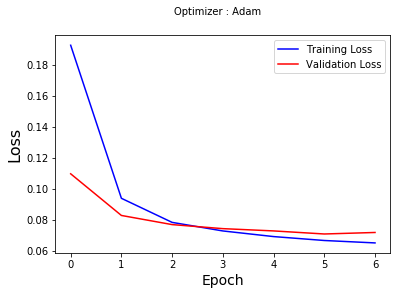

In [ ]:
#plotting Loss
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
# Compiling Model using optimizer
opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_sgd = model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2, validation_data=(X_val, y_val),
         callbacks=callbacks)  # starts training

Train on 95742 samples, validate on 31915 samples
Epoch 1/20
 - 6s - loss: 0.0601 - val_loss: 0.0687
Epoch 2/20
 - 5s - loss: 0.0575 - val_loss: 0.0674
Epoch 3/20
 - 5s - loss: 0.0567 - val_loss: 0.0671
Epoch 4/20
 - 5s - loss: 0.0565 - val_loss: 0.0670
Epoch 5/20
 - 5s - loss: 0.0564 - val_loss: 0.0669
Epoch 6/20
 - 5s - loss: 0.0564 - val_loss: 0.0671


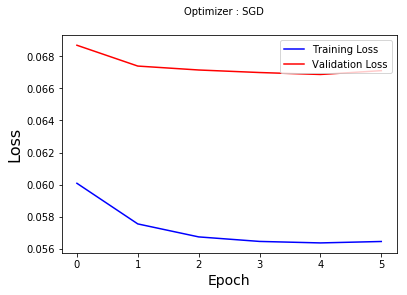

In [ ]:
#plotting Loss
plt.suptitle('Optimizer : SGD', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_sgd.history['loss'], color='b', label='Training Loss')
plt.plot(hist_sgd.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
# Compiling Model using optimizer
opt = Adadelta()
model.compile(loss='binary_crossentropy',optimizer=opt)
# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adad = model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2, validation_data=(X_val, y_val),
         callbacks=callbacks)  # starts training

Train on 95742 samples, validate on 31915 samples
Epoch 1/20
 - 7s - loss: 0.0585 - val_loss: 0.0702
Epoch 2/20
 - 6s - loss: 0.0580 - val_loss: 0.0683
Epoch 3/20
 - 6s - loss: 0.0585 - val_loss: 0.0677
Epoch 4/20
 - 6s - loss: 0.0578 - val_loss: 0.0675
Epoch 5/20
 - 6s - loss: 0.0580 - val_loss: 0.0692


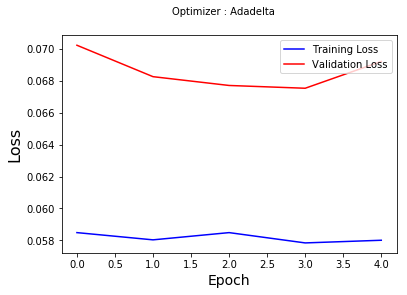

In [ ]:
#plotting Loss
plt.suptitle('Optimizer : Adadelta', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adad.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adad.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# Best Model

In [ ]:
# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
model.fit(X_train, y_train, batch_size=400, epochs=5, verbose=2, validation_data=(X_val, y_val),
         callbacks=callbacks)  # starts training

Train on 95742 samples, validate on 31915 samples
Epoch 1/5
 - 7s - loss: 0.0625 - val_loss: 0.0756
Epoch 2/5
 - 6s - loss: 0.0609 - val_loss: 0.0695
Epoch 3/5
 - 6s - loss: 0.0601 - val_loss: 0.0709


# Predict on test data

In [ ]:
# convert test to sequence and padding the sequence
sequences_test=tokenizer.texts_to_sequences(X_test)
X_test2 = pad_sequences(sequences_test,maxlen=X_train.shape[1])

In [ ]:
# Creating empty prediction array
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

# Predict on train, val and test datasets
pred_train = model.predict(X_train)
pred_test = model.predict(X_test2)
pred_val = model.predict(X_val)

# Emply array to collect AUC scores
AUC = np.zeros((3,6))
AUC

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
from sklearn import metrics
for i,x in enumerate(col):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], pred_train[:,i]),
                    metrics.roc_auc_score(y_val[:,i], pred_val[:,i]),
                    metrics.roc_auc_score(y_test[x], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],", Val AUC:",auc[1],", Test AUC:",auc[2])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Val AUC:",avg_auc[1],", Average Test AUC:",avg_auc[2])

toxic Train AUC: 0.9855551872720669 , Val AUC: 0.9579506535146012 , Test AUC: 0.9552147192256993
severe_toxic Train AUC: 0.9893364993444375 , Val AUC: 0.9792856812522668 , Test AUC: 0.9815730689206068
obscene Train AUC: 0.991274463447102 , Val AUC: 0.9745716601579055 , Test AUC: 0.9825372559263932
threat Train AUC: 0.955835870593275 , Val AUC: 0.90522490139277 , Test AUC: 0.926683839950787
insult Train AUC: 0.9864440087882215 , Val AUC: 0.9681527319797465 , Test AUC: 0.9708460797349026
identity_hate Train AUC: 0.9646761499165266 , Val AUC: 0.9303174839363928 , Test AUC: 0.9286648452238085
Average Train AUC: 0.9788536965602717 , Average Val AUC: 0.9525838520389471 , Average Test AUC: 0.9575866348303662
